# Capstone Project 1 - Final Report

## Introduction

In 2008 a Portugese bank began a marketing campaign to it's clients. Over the next three years clients were contacted and asked if they wanted to open a term deposit. The results of this capmaign was analysed in the research paper titled 'Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methedology', they developed a model which could predict whether or not a client would open a term deposit. On the basis of this model they gained insights which they hoped would help managers improve the performance of their direct marketing campaigns.

The researchers made a portion of the of the marketing data set available to the public, it contains the information of 45211 clients who were contacted, however due to privacy concerns some of the fields were redacted. For this project I will explore this data set and try to create my own predictive models, I will also try to gain insights which will be able to help future marketing campaigns.

## Exploritory Data Analysis

We will start by importing the data, and analysing the overall structure of the data set.

In [784]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
%matplotlib inline

In [810]:
# Load the data into a pandas data frame
bank = pd.read_csv('bank_full.csv', delimiter=',')

To get a better idea of what the data set looks like we look at the head,  description, and data types of the data set

In [739]:
print(bank.head())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  year  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may  2008       261         1   -600         0  unknown  no  
1  unknown    5   may  2008       151         1   -600         0  unknown  no  
2  unknown    5   may  2008        76         1   -600         0  unknown  no  
3  unknown    5   may  2008        92         1   -600         0  unknown  no  
4  unknown    5   may  2008       198         1   -600         0  unknown  no  


In [673]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
age           45211 non-null int64
job           45211 non-null object
marital       45211 non-null object
education     45211 non-null object
default       45211 non-null object
balance       45211 non-null int64
housing       45211 non-null object
loan          45211 non-null object
contact       45211 non-null object
day           45211 non-null int64
month         45211 non-null object
year          45211 non-null int64
duration      45211 non-null int64
campaign      45211 non-null int64
pdays         45211 non-null int64
pdays_bool    45211 non-null int64
previous      45211 non-null int64
poutcome      45211 non-null object
y             45211 non-null object
dtypes: int64(9), object(10)
memory usage: 6.6+ MB


In [5]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


From this we can see that our data frame has 45211 rows and 17 columns, each row contains the details related to one client. Each column represents a feature or variable of the data set, we have 16 independent variables and one dependent variable which is called 'y', it represents the outcome of the marketing campaign.

We will now explore the important variables of our dataset

#### Output variable - y

This is binary output variable, it tells us whether or not the marketing campaign resulted in the client opening a term deposit or not. From the graph below we can see that the outcome is imbalanced, of the 45211 clients who were contacted, only 11.7% opened a term deposit. 

This may be problematic for us since we are trying to model the data, yet we have such an imbalanced data set. It is for this reason that when we approach the model creation we must be cautions with regards to what evaluation metric we use. The reason for this is that if we use a basic evaluation technique such as accuracy, even a naive classifier which assumes that every client will decline to open a term deposit, will score an accuracy of 88.3%. 

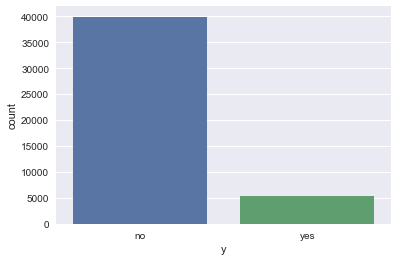

In [6]:
sns.countplot(x="y", data=bank)

In [7]:
# Proportion of yes/no

# we'll start off by counting the total number of people who did and didn't subscribe
ycount = bank['y'].value_counts()
# we need to count the number of total observations
rowcount = bank.shape[0]-1

print('Proportion yes: ' + '{0:2.3f}'.format((ycount[1]/rowcount)))
print('Proportion no: ' + '{0:2.3f}'.format((ycount[0]/rowcount)))

# We'll save the overall proportion of successes as the variable expected, this will help us with our chi squared tests
expected = ycount[1]/rowcount

Proportion yes: 0.117
Proportion no: 0.883


#### Age

This variable records the age of the client when they were contacted by the marketer. We use a histogram and boxplot to get an idea of the distribution of our data. We also use a boxplot graph to compare the age distribution of the people who opened term deposit accounts versus those who didn't. It looks as though the customers who said no are slightly older that those who said yes, however it is not sufficient to read this from the graph. We must perform a statistical test to determine if their is a statistically significant difference

Although there are a number of outliers in our dataset, since they are all under 100 years old, it is probably safe to assume that no error has been made in recording these customers age, and they are legitimatly that old.

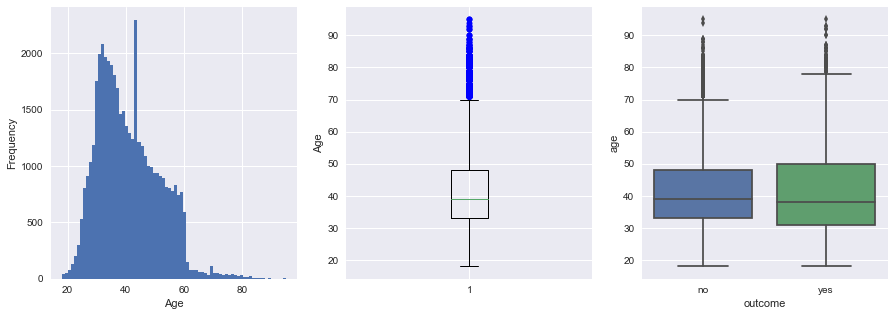

In [8]:
plt.subplot(1, 3, 1)
ageplt = bank.age.plot( kind='hist', bins = 74, figsize=(15,5))
plt.xlabel('Age')

plt.subplot(1, 3, 2)
agebox = plt.boxplot(bank.age, 0, 'b')
plt.ylabel('Age')

plt.subplot(1, 3, 3)
agebox2 = sns.boxplot(x="y", y="age", data=bank)
agebox2.set(xlabel='outcome')

#### Job

It's interesting to look at the variations in the success rate between the groups. While it is hardly surprising to see retirees subscribing to term deposits some other categories are a little more surprising, such as the the success rate with blue-collar workers, students and the unemployed. This is contrasted with the low success rate among managers, who one would assume would have the financial means to hold a diverse investment portfolio, which may include term deposits. However it's difficult to deduce from the dataset why there is such a large disparity in success rate between the groups.

One problem which we can see from the data is that there is a group of customers, for who their job is unknown. When we look at the proportion of customers who opened a term deposit and did not list their occupation, versus the overall proportion of success, we can see that they are almost identical. Since they are identical and since there are so few customers who don't list their occupation, we will drop these customers when we clean the data set.

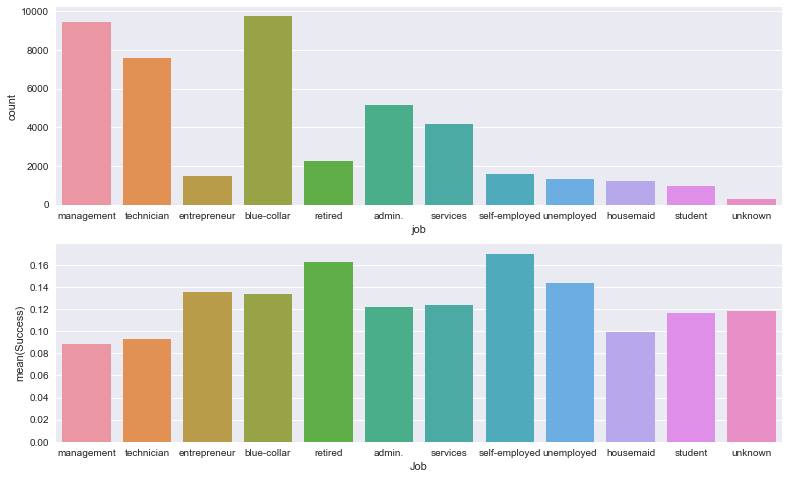

In [544]:
# We first graph the job titles and their respective totals
x = ['management', 'technician','entrepreneur','blue-collar','retired', 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student', 'unknown']
fig, axes = plt.subplots(figsize=(13, 8))
plt.subplot(2, 1, 1)
sns.countplot(x="job", data=bank, order=x)

# We then want to graph the which shows how successful the campaign was with each job category, to do this we first need to build a data frame which shows the proportion of success, grouped by job
jobsuccess = bank['job'].loc[bank['y']== 'yes'].value_counts()
jobcount = bank['job'].value_counts()
X = pd.DataFrame(columns=['Job','Success'])

Job=[]
Success=[]
for item in range(len(jobcount)):
    Job.append(jobcount.keys()[item])
    Success.append(jobsuccess[item]/jobcount[item])

Proportion = {'Job':Job, 'Success':Success}
X = pd.DataFrame(Proportion)

plt.subplot(2, 1, 2)
sns.barplot(x='Job', y='Success', data=X, order=x)

#### Month

It's interesting to see how dramatic the variation in success rate is between the months, especially when we consider that the dataset relates to a marketing campaign which took place over three years. It seems that most of the calls were made in May, however this is the month which had the lowest success rate, however on the months which had the least ammount of calls such December and March, the success rate was the highest.

As we will see in the modeling section of the capstone project, there is a statistical significance between the months, rather than the variation being due to random noise. It would have been extremly useful for the Bank to have investigated the disparity in success rate between the months. The best guess I can come up with is that the months relate to when the term deposits come to maturity, thus the high success rate is due to the bank contacting existing subscribers and asking them if they want to roll over the acocunt for another term.

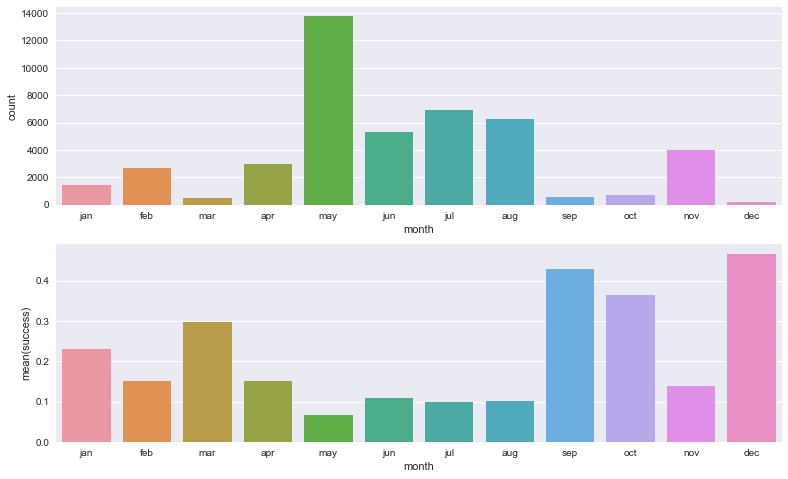

In [545]:
# Let's look at the success rate, categorised by month
# We first graph the Month and their respective totals
x = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
fig, axes = plt.subplots(figsize=(13, 8))
plt.subplot(2, 1, 1)
sns.countplot(x="month", data=bank, order=x)

# We then want to graph the which shows how successful the campaign was by month, to do this we first need to build a data frame which shows the proportion of success, grouped by month
monthsuccess = bank['month'].loc[bank['y']== 'yes'].value_counts()
monthcount = bank['month'].value_counts()
X = pd.DataFrame(columns=['month','Success'])

month=[]
success=[]
for item in range(len(monthcount)):
    month.append(monthcount.keys()[item])
    success.append(monthsuccess[item]/monthcount[item])

Proportion = {'month':month, 'success':success}
X = pd.DataFrame(Proportion)

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='success', data=X, order=x)

#### Duration

The above figures show the distribution of the durations of the final phone call. From the histogram on the left we can see that there is a strong inbalance in the duration, with most phone calls being fairly short. Since the overall success rate is 11.7%, we might guess that unsuccesful calls tend to be shorter than succesful ones.

If we look at the boxplot on the right, it confirms this guess. The successful calls tend to be much longer than the unsuccesful calls. This makes intuitive sense since customers who are interested in the will spend more time with the marketer, asking questions about the product. It will also take additional time for the customer to sign up for the product. This is in comparison to the uninterested customer, who is likely to be unwilling to spend time one the phone with the marketer.

However this variable is problematic since we can only know the length of the final call once we know the outcome of the call, i.e. whether or not the customer opened a term deposit account. The problem arrose when researchers confused causation with correlation, instead of merly stating that there was a correlation between the two, they made the recomendation that the telemarketers should try to stay on the line for as long as possible with the customers since it increases the probability of them opening a term deposit.

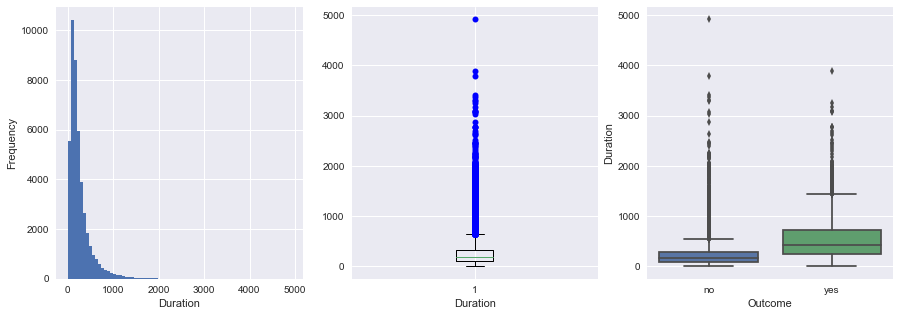

In [33]:
# Let's look at the duration of the final call
plt.subplot(1, 3, 1)
durationplt = bank.duration.plot( kind='hist', bins = 74, figsize=(15,5))
plt.xlabel('Duration')

plt.subplot(1, 3, 2)
durationbox = plt.boxplot(bank.duration, 0, 'b')
plt.xlabel('Duration')

plt.subplot(1, 3, 3)
durationbox2 = sns.boxplot(x="y", y="duration", data=bank)
durationbox2.set(xlabel='Outcome')
durationbox2.set(ylabel='Duration')

#### Balance

This is the account balance of the customer in Euros. We can see that on average customers who subscribe to a term deposit has a larger account compared to the customers who don't. This is hardly surprising, however what is surprising is the low account balance of both groups, even the group who did subscribe had on average less than 1000 Euros. It is important to note that this is not a measure of the total networth of our customer, they likely have other assets.

Although there is a large spread of account balancesranging from those with small negative balances, to those with over 100,000 Euros. Although these are outliers these account balances are entierly resonable, thus we won't touch them when we clean the data set. 

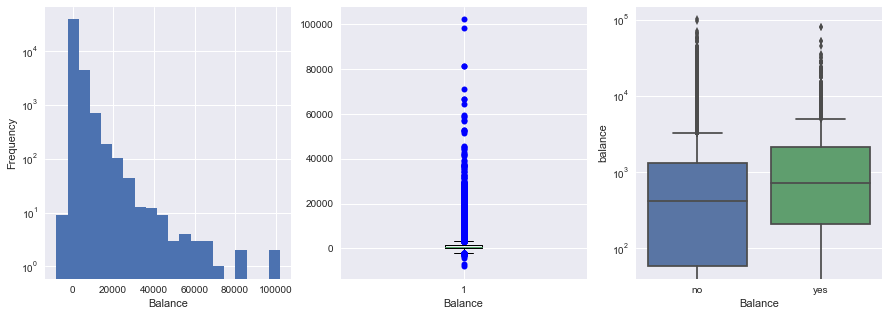

In [528]:
plt.subplot(1, 3, 1)
balanceplt = bank.balance.plot( kind='hist', bins = 20, figsize=(15,5))
plt.xlabel('Balance')
balanceplt.set_yscale('log')


plt.subplot(1, 3, 2)
balancebox = plt.boxplot(bank.balance, 0, 'b')
plt.xlabel('Balance')
#plt.yscale('log')


plt.subplot(1, 3, 3)
balancebox2 = sns.boxplot(x="y", y="balance", data=bank)
balancebox2.set(xlabel='Balance')
plt.yscale('log')

#### Pdays

This variable records the number of days that passed by after the client was last contacted from a previous campaign. From the comparitive boxplot on the right, we can see that the customers who were previously contacted are more likely to open an account.

We can see that there are many outliers in our data set, however since the campaign was conducted over a three year period, a pdays value of just under 900 is entierly resonable, thus we won't remove those values in our data cleaning.

Note that the ajority of the clients in the data set weren't contacted in a previous campaign, we use a placeholder of -1 to signify that the customer was not previously contacted. Since there are too many clients who were not contacted, it is not fesable to remove them. The most sensible way of dealing with these missing values is to keep the placeholder of -1.

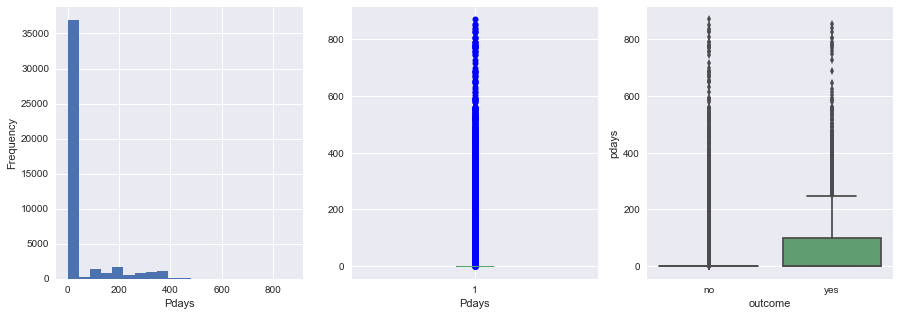

In [865]:
# Pdays - , note -1 means not previously contacted

plt.subplot(1, 3, 1)
pdaysplt = bank.pdays.plot( kind='hist', bins = 20, figsize=(15,5))
plt.xlabel('Pdays')

plt.subplot(1, 3, 2)
pdaysbox = plt.boxplot(bank.pdays, 0, 'b')
plt.xlabel('Pdays')

plt.subplot(1, 3, 3)
pdaysbox2 = sns.boxplot(x="y", y="pdays", data=bank)
pdaysbox2.set(xlabel='outcome')
#plt.yscale('log')

#### Education

Is the highest level of education attained by the customer. Two interesting patterns can be observed, firstly we can see that as the level of education of the customer increases, so too does the liklihood that the customer will open a term deposit. Secondly, we can see that the customers who didn't provide and education level have the second highest success rate. Since the rate at which they open accounts is about 2% above the global mean of 11.7%, we can see that there is something statistically significant happening here. Thus I feel that the best way to treat this variable is to treat is as a legitimate fourth category.

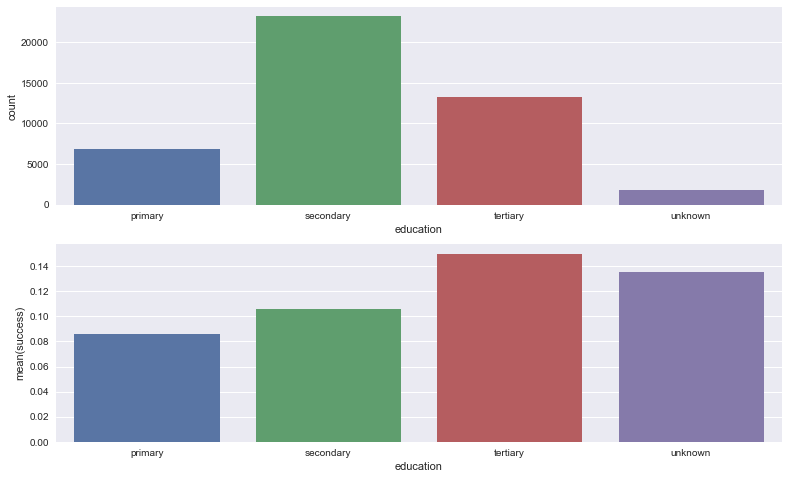

In [548]:
# We first graph the education level and their respective totals
x = ['primary','secondary' ,'tertiary' , 'unknown']
fig, axes = plt.subplots(figsize=(13, 8))
plt.subplot(2, 1, 1)
sns.countplot(x="education", data=bank, order=x)

# We then want to graph the which shows how successful the campaign was with each education level, to do this we first need to build a data frame which shows the proportion of success, grouped education level
educationsuccess = bank['education'].loc[bank['y']== 'yes'].value_counts()
educationcount = bank['education'].value_counts()
X = pd.DataFrame(columns=['education','Success'])

education=[]
success=[]
for item in range(len(educationcount)):
    education.append(educationcount.keys()[item])
    success.append(educationsuccess[item]/educationcount[item])

Proportion = {'education':education, 'success':success}
X = pd.DataFrame(Proportion)

plt.subplot(2, 1, 2)
sns.barplot(x='education', y='success', data=X, order=x)

#### Marital Status

From the graph we can see that there is a sizable disparity in success rates between singles and married people, the single customers appear to have a 5% higher success rate than customers who are married.

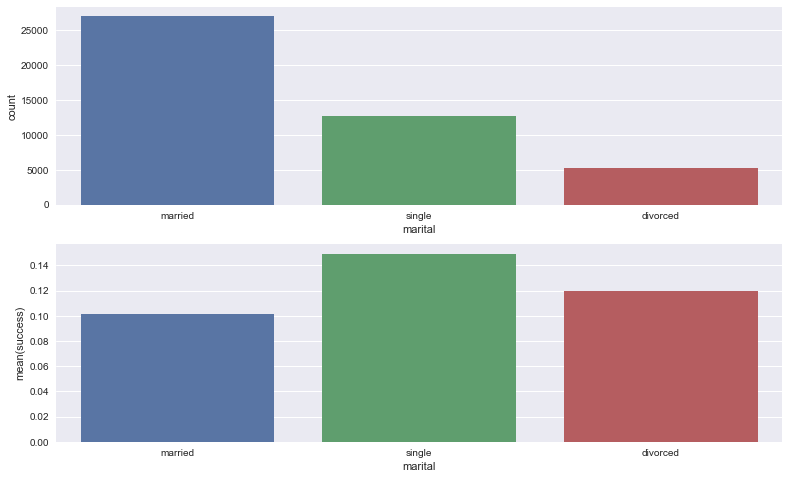

In [243]:
# We first graph the Marital Status and their respective totals
fig, axes = plt.subplots(figsize=(13, 8))
plt.subplot(2, 1, 1)
sns.countplot(x="marital", data=bank)

# We then want to graph the which shows how successful the campaign was with each marital category, to do this we first need to build a data frame which shows the proportion of success, grouped by marital status
maritalsuccess = bank['marital'].loc[bank['y']== 'yes'].value_counts()
maritalcount = bank['marital'].value_counts()
X = pd.DataFrame(columns=['marital','Success'])

marital=[]
success=[]
for item in range(len(maritalcount)):
    marital.append(maritalcount.keys()[item])
    success.append(maritalsuccess[item]/maritalcount[item])

Proportion = {'marital':marital, 'success':success}
X = pd.DataFrame(Proportion)

plt.subplot(2, 1, 2)
sns.barplot(x='marital', y='success', data=X)

## Data preparation

To clean the data set we will:
- Drop the rows of our data set where the job is unknown, since we saw in our EDA the average of the group is almost the same as our data set, and there is only 288 rows, it is resonable to drop the rows
- Encode our categorical data using a lable encoder. We will map the month values using kep pair values since we care about the order of the labels. For the rest of the categorical variables we will use a label encoder 



In [811]:
# We drop the 288 rows where the job is unknown
bank = bank.drop(bank[bank.job=='unknown'].index)

In [812]:
# Map function to convert the months to numeric
bank['month'] =bank['month'].map({
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
    })

In [813]:
# We then initalise the label encoder and use it to encode the rest of our catgorical variables
lb_make = LabelEncoder()

categories = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y']
for col in categories: 
    bank[str(col)+"_code"] = lb_make.fit_transform(bank[col])    

There are a number of features which I found which improved the performance of the model, they are:

- The date
- The difference between the CPI and the term deposit rate
- The level of unemployment
- The CPI
- The change in the monthly unemployment rate between the current and previous month


Until now Data Scientists modeling this data set have used a feature numbering the day of the month, and the month, looking at previous research it appears that these features are statistically significant. However the problem with the current approach is that it misses the bigger picture, the data set represents a marketing campaign which was conducted over a three year period. Thus it is naive to treat days and months as if they were homogenous, e.g. it is naive to say that July 2008 is equivalent to July 2010. There are no doubt social and economic factors which are affecting the consumers behaviour, since these factors are constantly changing it made sense to add in a date variable.

Another factor which had a large affect on the performance of the model was the addition of a feature which captured the difference between the Portugese Consumer Price Index and the Portugese three month term deposit rate. The rational behind this feature is that customers are rational, rather than looking at the aggregate rate (i.e. the term deposit rate) they are concerned with the real rate of return, meaning the difference between the term deposit rate and the CPI.

The final three feature I have included are the level of unemployment, CPI, and the change in the monthly unemployment rate between the current and previous month. These features lead to modest improvements in the models performance.

The data for these dates has been stored in a file called features, we will load in the file as a data frame and merge it with our bank data frame.

In [814]:
# Create date feature using the format DDMMYYYY
bank['date'] = (bank['day']*1000000)+(bank['month']*10000)+bank['year']

# Create a 'features' column so that we have a common colum to merge our dataframes
bank['features'] = (bank['month']*10000)+bank['year']

In [815]:
# Load features into a data frame
features = pd.read_csv('features.csv', delimiter=',')

In [866]:
# Merge on the common variable 
bank2 = pd.merge(bank, features, on="features")

In [817]:
# Drop redundant columns and split into input and output variables
X = bank2.drop(['y_code', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'y', 'month', 'day', 'year', 'features'],axis=1)
y = bank2['y_code']

## Model creation

Now that we start modeling our data it is important for us to understand exactly what we are trying to model. Although some may treat this data set as if it were a classification problem, I feel as though it is more or a predictive one. By this I mean that we are not trying to predict whether or not someone will open a term deposit account, i.e. it is not a binary classification problem. Rather we are trying to model the probability that each customer will open a term deposit account.

Of the research I have seen on this data set, they use the area under the reciever opperator curve (AUC) as their evaluation metric. In this problem the outcome is binomial, what we are trying to do is construct a probability distribution for each category of outcome. The reason why the AUC is such a good choice for en evaluation metric is that the closer the AUC is to one, the better we have sepperated the distributions, meaning that our model does a better job of differentiating between those who will open an account versus those who will not.

#### Linear regression

We will start off with a simple linear regression, this will serve as a baseline to compare the accuracy of our other models

In [818]:
# We then split the data into a training and testing set and train the decision tree 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [819]:
# Initalise the linear regressor, fit it to the training data and evaluate on the test set
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [820]:
print(roc_auc_score(y_test, lr_pred))

0.921334117794


We can see that our linear model does an excelent job of modeling the data set, but let's see if we can do any better

#### Decision tree

In [821]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
print(roc_auc_score(y_test, predictions))

0.722155691208


Although the AUC score is certainly better than a random guess, which would give a score of 0.5, it is much worse than our linear model. Perhapse using a collection of decision trees we will be able to yield better performance.

#### XGBoost

XGBoost, which is short for extreme gradient boosting uses a collection of weak learners to build a predictive model. A good analogy to explain how this process works would be to imagine a collection of decision trees voting on how probable a customer is of opening a term deposit account, although each decision tree may only be slightly better than a random guess, a whole collection of trees may do a great job or predicting the outcome.

In [822]:
bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

In [850]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic"}
    
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, metrics="auc", as_pandas=True)
print(cv_results[-1:])

   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
9       0.942628      0.000741        0.958505        0.00075


With out any parameter tunning we can already see that our XGBoost performs better than our other previously tested models. After only 10 rounds of boosting we have an AUC for our test data of 0.942628. This is already on par with what previous research was able to acheive! 

Let's do some parameter tunning to see if we can further improve our model. We'll start off with a gridsearchto find the optimal parameters for our model. 

In [ ]:
param_test1 = {
    'max_depth':[3,4,5],
    'learning_rate':[0.078, 0.1, 0.12],
    'subsample':[0.8, 0.91, 1], 
    'colsample_bytree':[0.90, 0.95, 1],
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(n_estimators=400, objective= 'reg:logistic', nthread=4, seed=27), 
param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=15)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Now that we have have found the optimal parameters we perform cross validation to check the accuracy of our model. We specify that if test AUC doesn't improve after 50 rounds we should stop the test. We also specify the number of folds used in the cross validation, in our case we use 15 folds.

In [864]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":5, "learning_rate":0.078, "subsample":0.91, "colsample_bytree":0.95}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, num_boost_round=400, as_pandas=True, metrics='auc', nfold=15, early_stopping_rounds=50, seed=27)
print(cv_results[-1:])

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.898719      0.010001        0.903646       0.002010
1         0.908866      0.009643        0.913969       0.005728
2         0.916129      0.007046        0.921053       0.004340
3         0.921871      0.006487        0.926264       0.002425
4         0.924291      0.006407        0.928347       0.002237
5         0.925293      0.006475        0.929670       0.002238
6         0.925866      0.006401        0.930498       0.002198
7         0.927059      0.006578        0.931566       0.002750
8         0.928481      0.006078        0.933013       0.003192
9         0.929126      0.005873        0.933627       0.003190
10        0.930304      0.006354        0.934747       0.003459
11        0.931221      0.006041        0.935970       0.003186
12        0.932493      0.006202        0.937436       0.002918
13        0.934136      0.006233        0.938880       0.001867
14        0.935149      0.006010        

We find that after 262 rounds of boosting, we arrive at a training AUC of 0.946861.

We will now model how the accuracy of our model improves as we increase the amount of trees, i.e. the ammount of trees which make up our model. We can see how as the model complexity increases so too does the accuracy, however there are diminishing returns, it reaches a point at around 200 rounds where each additional round does little to improve the model accuracy. This is the reason why in our last test although we specified a maximum of 400 rounds the test stopped after only 262.

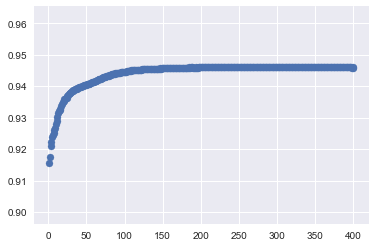

In [320]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":5, "learning_rate":0.078, "subsample":0.91, "colsample_bytree":0.95}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, num_boost_round=400, as_pandas=True, metrics='auc', nfold=15)
results = pd.DataFrame(cv_results)
results['round'] = range(1, len(results) + 1)
plt.scatter(results['round'], results['test-auc-mean'])

We will now look at how the size of the training data set affects the accuracy of our model. We can see that as we increase the ammount of data which we feed our model, we get an improvement of model accuracy, however once again there are diminishing returns.

In [847]:
# Let's look at how the size of the training data affects the AUC
data_sizes =  (0.995, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0)
llst = []

def training_size():
    for sample in data_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=sample)
        bank_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
        cv_results = xgb.cv(dtrain=bank_dmatrix, params=params, nfold=5, num_boost_round=400, as_pandas=True, metrics='auc')
        llst.append({'Size': ((1-sample)*len(X)), 'AUC': cv_results["test-auc-mean"][399]})
    return llst

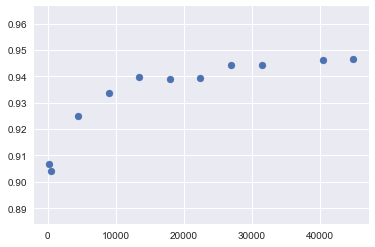

In [848]:
scores = pd.DataFrame(training_size())
plt.scatter(scores.Size, scores.AUC)

We now create a graph to show feature importance. From it we can see that duration is the most important feature for predicting outcome.

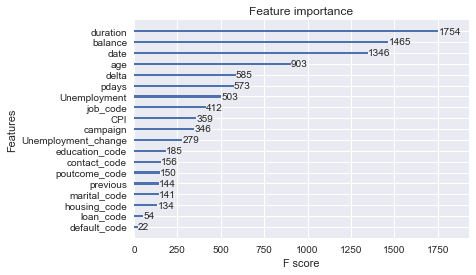

In [836]:
model = xgb.train(params=params, dtrain=bank_dmatrix, num_boost_round=400)
xgb.plot_importance(model)
plt.show()

## Model Evaluation

The reason that I have not treated this problem as a classification problem, is that since we are modeling probabilities, a decision must be made for us to classify our customers. Classification would essentially mean that we take a particular level of probability and classify every point above that level as a success and every point below as a failure. 

The reason that this is so problematic is that there will invariably be a trade off between accuracy and recal. For example is we were to decide to contact everyone who we predict has a probability of over 90% of opening a term deposit, we would have good accuracy, however our recall would be poor since we would miss out on all the other customers who, had they been contacted would have said yes.

Thus to evaluate the model I will use the model which I have created to predict the probability of each customer in the training set signing up for a term deposit. The results of the predictions will be shown in a graph which will show how many customers would be needed to be contacted, in order to reach a given ammount of the total number of customers who would have opened a term deposit in the training set.

There was also one important change which was made to the model which I use in the evaluation section vs the model which I use in the model creation section, that is the removal of the 'duration' variable. As I have said earlier, the duration variable is problematic since it can only be known once the outcome is known, since we don't know the length of the final call before until we know whether or not the customer has opened a term deposit account. Thus this feature, although highly correlated to our outcome variable, can not be used for a predictive model. 

As we will see in the cross validation section, the AUC score of our model falls from ### to ###, although this is a large decrease, the model still does a good job of predicting the training data. The reason which I kept the 'duration' variable in the model building section is that it allows some consistency between our model and the models developed by other researchers, and thus the AUC score which we derive is directly comparable to theirs.

In [837]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
xg_cl = xgb.XGBClassifier(objective="reg:logistic", n_estimators=400, learning_rate=0.078, subsample=0.91, colsample_bytree=0.95, max_depth=5)
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict_proba(X_test)

In [838]:
preds = pd.DataFrame(preds)
y_test = pd.DataFrame(y_test)
preds['number'] = range(1, len(preds) + 1)
y_test['number'] = range(1, len(y_test) + 1)
result = pd.merge(preds, y_test, on="number")
#result.to_csv("results.csv")

In [839]:
result = result.sort_values(by=[1], ascending=False)
#result['y_code'][1000:].sum()
result['number'] = range(1, len(y_test) + 1)
#result.reset_index()

In [840]:
total_yes = result['y_code'].sum()
recall = []
calls = []

for x in range(len(result)):
    rec = result['y_code'][:x].sum()/total_yes
    called = x/len(result)
    recall.append(rec)
    calls.append(called)
    
result['recall'] = recall
result['called'] = calls
#evall = pd.DataFrame(columns=['probability', 'recall'])
result.to_csv("results.csv")

#for percent in range(0,1,0.05)
#result['recall'] = result['y_code'].values[0:int(result['number'].values)].sum()/total_yes

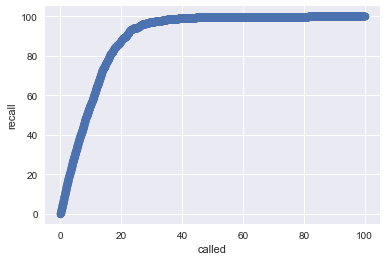

In [841]:
plt.scatter(result['called']*100, result['recall']*100)
plt.xlabel('called')
plt.ylabel('recall')

From the graph above we can see if we were to rank the customers in the training set in order of how likely we predict that they are of opening a term deposit, that there is a trade off between the ammount of people we call and the percentage of the total term deposit accounts which we could have opened. For example by calling #% of the customers in the training set we would have reached ##% of the total customers in the training set who would have opened term deposit accounts.

We can see that the model does a good job of predicting the probability that a customer will open an account, however the difficulty of this problem is that if we wish to all of the potential customers who would have opened an account, we need to contact almost all of the customers on our list. THe reason for this is that since we have so many customers (### in our set), even if the bottom half of our ranked customers only have a 2% chance of opening an account, by not calling them we would have missed out on ### term deposits being opened.

It is for this reason that I have chosen to evaluate this as a predictive problem as opposed to a classification problem. Since classification would require us to choose a threshold above which we call the customers, and since there is an inherent tradeoff between the percentage of customers which we call, percentage of the total outcome had we called all customers, I feel that the selection of this threshold is a management decision rather than a data science problem.